In [1]:
import numpy as np
import scipy.signal as signal
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
import segyio

In [3]:
def parse_text_header(segyfile):
    '''
    Format segy text header into a dictionary
    '''
    
    raw_header = segyio.tools.wrap(segyfile.text[0])
    
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    
    # Format in dict
    dict_header = {}
    i = 1
    
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        dict_header[key] = item
        
    return dict_header

In [4]:
def parse_binary_headers(segyfile):
    '''
    Parse the binary headers into a pandas dataframe.
    Column names are defined from segyio library internal binfield names
    '''
    # Get all binary header keys
    binary_keys = segyio.binfield.keys
    
    # Initialize dataframe with binary headers as columns
    df = pd.DataFrame(index=range(1,2), columns=binary_keys.keys())
    
    # Fill dataframe with all binary header values
    for k, v in binary_keys.items():
        df[k] = segyfile.bin.get(v)
        
    return df

In [5]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    '''
    # Get all trace header keys
    headers = segyio.tracefield.keys
    
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces+1), columns=headers.keys())
    
    # Fill dataframe with all trace header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
        
    return df

In [6]:
data_path = "cdpgathers_82-140.sgy"

In [7]:
with segyio.open(data_path, ignore_geometry=True) as f:
    
    # Get basic attributes
    n_traces    = f.tracecount                  # Number of traces
    sample_rate = segyio.tools.dt(f)/1000       # Sampling trace in micro second
    n_samples   = f.samples.size                # Number of samples in each trace data
    t_domain    = f.samples                     # Discretized time domain milli second
    tr_data     = f.trace.raw[:]                # Get all trace data into numpy array
    
    # Load headers
    text_headers  = parse_text_header(f)
    bin_headers   = parse_binary_headers(f)
    trace_headers = parse_trace_headers(f, n_traces)
    
print(f'Number of Traces: {n_traces}, Number of Samples: {n_samples}, Sample Rate: {sample_rate} ms')

Number of Traces: 110925, Number of Samples: 1650, Sample Rate: 2.0 ms


In [8]:
for col in trace_headers.columns: #before rename
    print(col)

TRACE_SEQUENCE_LINE
TRACE_SEQUENCE_FILE
FieldRecord
TraceNumber
EnergySourcePoint
CDP
CDP_TRACE
TraceIdentificationCode
NSummedTraces
NStackedTraces
DataUse
offset
ReceiverGroupElevation
SourceSurfaceElevation
SourceDepth
ReceiverDatumElevation
SourceDatumElevation
SourceWaterDepth
GroupWaterDepth
ElevationScalar
SourceGroupScalar
SourceX
SourceY
GroupX
GroupY
CoordinateUnits
WeatheringVelocity
SubWeatheringVelocity
SourceUpholeTime
GroupUpholeTime
SourceStaticCorrection
GroupStaticCorrection
TotalStaticApplied
LagTimeA
LagTimeB
DelayRecordingTime
MuteTimeStart
MuteTimeEND
TRACE_SAMPLE_COUNT
TRACE_SAMPLE_INTERVAL
GainType
InstrumentGainConstant
InstrumentInitialGain
Correlated
SweepFrequencyStart
SweepFrequencyEnd
SweepLength
SweepType
SweepTraceTaperLengthStart
SweepTraceTaperLengthEnd
TaperType
AliasFilterFrequency
AliasFilterSlope
NotchFilterFrequency
NotchFilterSlope
LowCutFrequency
HighCutFrequency
LowCutSlope
HighCutSlope
YearDataRecorded
DayOfYear
HourOfDay
MinuteOfHour
SecondOf

In [9]:
#rename specific column names
trace_headers.rename(columns = {'INLINE_3D':'inline','CROSSLINE_3D':'xline'
                                ,'CDP_X':'bin_x', 'CDP_Y':'bin_y'
                                ,'SourceX':'shot_x', 'SourceY':'shot_y','GroupX':'recv_x', 'GroupY':'recv_y'
                                ,'ReceiverGroupElevation':'recv_elev', 'SourceWaterDepth':'recv_dept'
                                ,'TRACE_SEQUENCE_FILE':'trace_index', 'EnergySourcePoint':'ffid' 
                               }, inplace = True) 
                                                                                                                  

In [10]:
for col in trace_headers.columns: #after rename, column name control !?
    print(col)

TRACE_SEQUENCE_LINE
trace_index
FieldRecord
TraceNumber
ffid
CDP
CDP_TRACE
TraceIdentificationCode
NSummedTraces
NStackedTraces
DataUse
offset
recv_elev
SourceSurfaceElevation
SourceDepth
ReceiverDatumElevation
SourceDatumElevation
recv_dept
GroupWaterDepth
ElevationScalar
SourceGroupScalar
shot_x
shot_y
recv_x
recv_y
CoordinateUnits
WeatheringVelocity
SubWeatheringVelocity
SourceUpholeTime
GroupUpholeTime
SourceStaticCorrection
GroupStaticCorrection
TotalStaticApplied
LagTimeA
LagTimeB
DelayRecordingTime
MuteTimeStart
MuteTimeEND
TRACE_SAMPLE_COUNT
TRACE_SAMPLE_INTERVAL
GainType
InstrumentGainConstant
InstrumentInitialGain
Correlated
SweepFrequencyStart
SweepFrequencyEnd
SweepLength
SweepType
SweepTraceTaperLengthStart
SweepTraceTaperLengthEnd
TaperType
AliasFilterFrequency
AliasFilterSlope
NotchFilterFrequency
NotchFilterSlope
LowCutFrequency
HighCutFrequency
LowCutSlope
HighCutSlope
YearDataRecorded
DayOfYear
HourOfDay
MinuteOfHour
SecondOfMinute
TimeBaseCode
TraceWeightingFactor
Ge

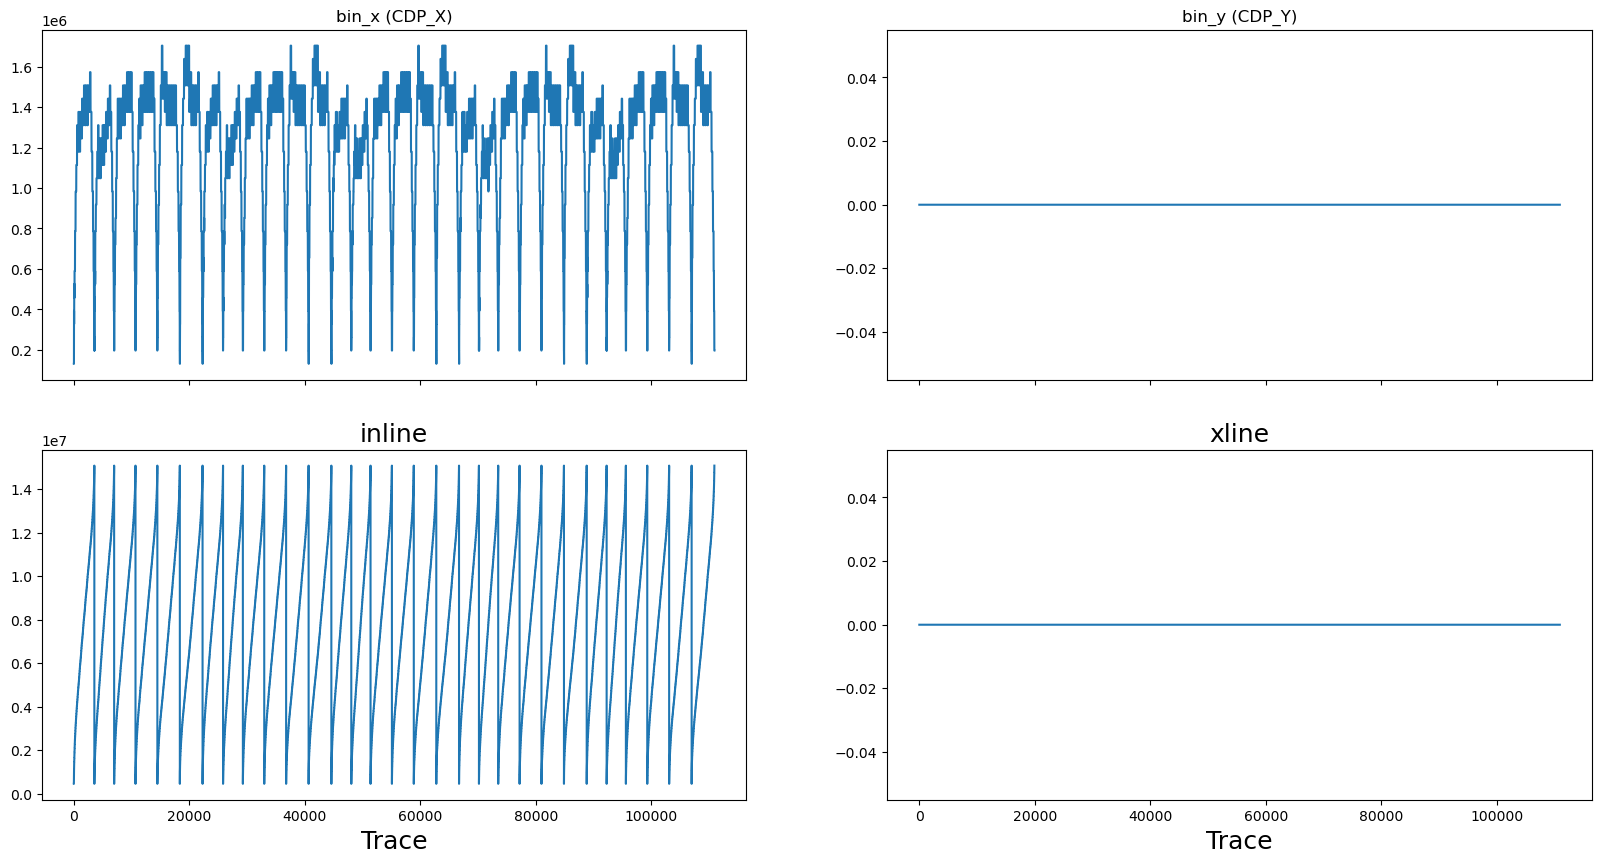

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex=True)


for ax, prop in zip(axs.ravel(), ["bin_x", "bin_y", "inline", "xline"]): #bin_x/y = cdp_x/y
    ax.plot(trace_headers[prop])
    ax.set_title(prop, fontdict={"fontsize":18})
    axs[0, 0].set_title('bin_x (CDP_X)')
    axs[0, 1].set_title('bin_y (CDP_Y)')
    

for ax in axs[1, :]:
    ax.set_xlabel("Trace", fontdict={"fontsize":18})

In [12]:
# GENERATE RANDOM INTEGER VALUES

#from random import seed
from random import randint
# seed random number generator
#seed(0)->seedle tekrar değişlik yapımcaya kdr random degerler sabit kalıyor

for i in range(len(trace_headers)):
    trace_headers['xline'].values[i] = randint(1, 100)
    trace_headers['inline'].values[i] = randint(1, 100)

In [13]:
trace_headers[['inline','xline']] #number check

,inline,xline
1,91,26
2,11,84
3,100,75
4,74,98
5,57,42
...,...,...
110921,35,31
110922,8,37
110923,18,54
110924,55,37


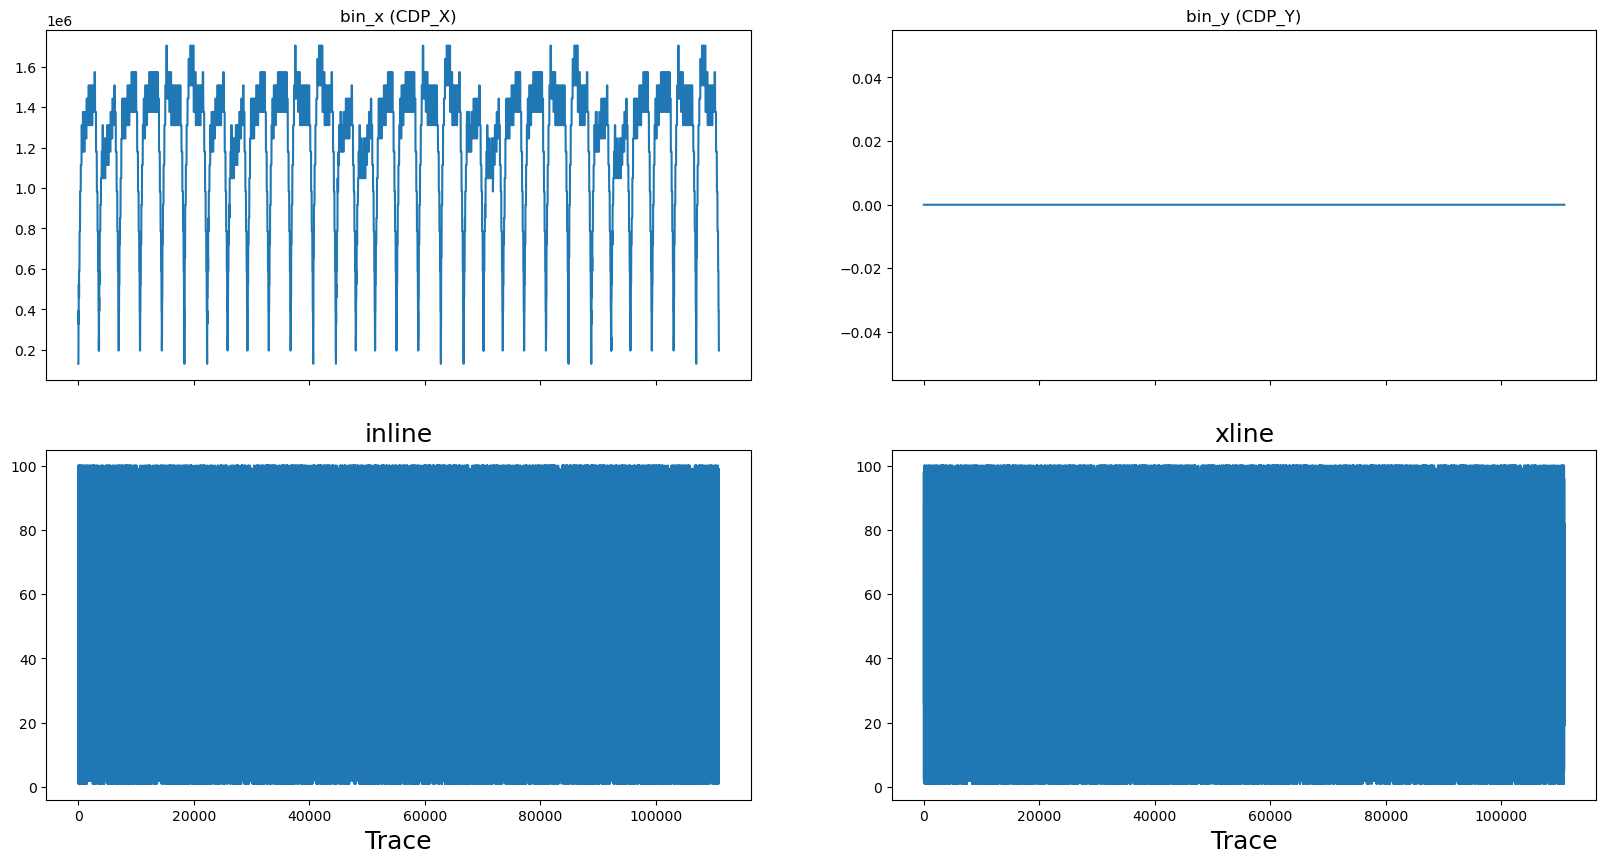

In [14]:
#GRAPH CHECK
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex=True)


for ax, prop in zip(axs.ravel(), ["bin_x", "bin_y", "inline", "xline"]): #bin_x/y = cdp_x/y
    ax.plot(trace_headers[prop])
    ax.set_title(prop, fontdict={"fontsize":18})
    axs[0, 0].set_title('bin_x (CDP_X)')
    axs[0, 1].set_title('bin_y (CDP_Y)')
    

for ax in axs[1, :]:
    ax.set_xlabel("Trace", fontdict={"fontsize":18})

In [16]:
def sort_data_headers(df, column_name, lower_limit, upper_limit):
    
    #df=df[df[column_name].between(lower_limit,upper_limit)]

    row_numbers = df[df[column_name].between(lower_limit,upper_limit)]
    
    sorted_value_row_numbers = {k: v for k, v in sorted(row_numbers[column_name].items(), key=lambda item: item[1])}
    sorted_value_row_numbers = pd.DataFrame(sorted_value_row_numbers.items(), columns=['Row Number', 'Value'])
    
    sorted_value_row_numbers = sorted_value_row_numbers.set_index('Row Number')

    #return row_numbers[column_name]
    
    return sorted_value_row_numbers#.iloc[252]

sort_data_headers(trace_headers,'inline',0,5) #play with parameters



,Value
Row Number,
34,1
43,1
276,1
414,1
429,1
...,...
110775,5
110784,5
110850,5
